# CNN Regression

In [1]:
import time
import json
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm  # Fortschrittsbalken
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
import ml_evaluation as ml_eval
import ml_helper
import ml_history
import dataset_generator as data_gen
# class imports
import HumorDataset as humor_ds
import EarlyStopping
import BalancedCELoss


In [ ]:
torch.manual_seed(0)
np.random.seed(0)


best_model_filename = 'best_cnn_reg_model.pt'

device = ml_helper.get_device(verbose=True)

In [ ]:
embedding_matrix, word_index, vocab_size, d_model = data_gen.create_embedding_matrix()

vocab_size = len(embedding_matrix)
d_model = len(embedding_matrix[0])
vocab_size, d_model = embedding_matrix.size()
print(f"vocab_size: {vocab_size}, d_model: {d_model}")

In [5]:
class CNN_HumorRegressor(nn.Module):
    def __init__(self, embed_dim, filter_sizes, num_filters, dropout=0.5):
        super(CNN_HumorRegressor, self).__init__()

        # Convolutional Layers mit verschiedenen Filtergrößen
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embed_dim)) 
            for fs in filter_sizes
        ])

        # Highway-Netzwerk für bessere Feature-Extraktion
        self.highway = nn.Linear(len(filter_sizes) * num_filters, len(filter_sizes) * num_filters)

        # Dropout zur Vermeidung von Overfitting
        self.dropout = nn.Dropout(dropout)

        # Fully Connected Layers
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [Batch Size, 1, Seq Length, Embed Dim]

        # Convolution + ReLU activation
        conved = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        # Max-Pooling über jede Feature-Map
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conved]

        # Feature-Vektor kombinieren
        cat = torch.cat(pooled, dim=1)

        # Highway-Netzwerk
        highway = F.relu(self.highway(cat))
        highway = self.dropout(highway + cat)

        # Fully Connected Layers
        fc_out = F.relu(self.fc1(highway))
        fc_out = F.relu(self.fc2(fc_out))
        return torch.sigmoid(self.fc3(fc_out))  # Sigmoid für Wertebereich [0, 1]


In [ ]:
def load_preprocess_data(path_data='data/hack.csv'):
    df = pd.read_csv(path_data)
    df = df.dropna(subset=['humor_rating'])

    df['y'] = df['humor_rating']
    X = df['text']
    y = df['y']
    return X, y

In [ ]:
X,y = load_preprocess_data()

ret_dict = data_gen.split_data(X, y)


In [ ]:
params = {
    # used for class balancing
    'equalize_classes_loss_factor': 0.15, # 0.15 (0.1 to 0.2)
    # training parameters
    'batch_size': 32, # 32 (16 to 64)
    'epochs': 10, # 100
    'lr': 1e-4, # 1e-5 (1e-6 to 1e-3)
    
    # CNN parameters
    'filter_sizes': [2, 3, 4],
    'num_filters': 150,
    
    # patience for early stopping
    'early_stopping_patience': 5, # 5 (3 to 10)

    # learning rate scheduler
    'lr_scheduler_factor': 0.5, # 0.1 (0.05 to 0.2)
    'lr_scheduler_patience': 3, # 3 (2 to 5)

    # model parameters
    'nhead': 2, # 5
    'num_layers': 3, # 6
    'hidden_dim': 10, # 50
    

    # regularization parameters
    'positional_dropout': 0.5, # 0.1 (0.1 to 0.5)
    'classifier_dropout': 0.5, # 0.1 (0.1 to 0.5)
    'weight_decay': 1e-2 # 0.0  (1e-6 to 1e-2)
}

# Model initialization
model = CNN_HumorRegressor(embed_dim=d_model, filter_sizes=params['filter_sizes'], num_filters=params['num_filters'], dropout=params['classifier_dropout'])
model.to(device)
print('model created')

In [ ]:
# NOTE: Info comes from data explore notebook: 280 is max length,
# 139 contains 80% and 192 contains 95% of the data
max_len = 280

train_dataset = humor_ds.TextDataset(ret_dict['train']['X'], ret_dict['train']['y'], word_index, max_len=max_len)
val_dataset =  humor_ds.TextDataset(ret_dict['val']['X'], ret_dict['val']['y'], word_index, max_len=max_len)
test_dataset =  humor_ds.TextDataset(ret_dict['test']['X'], ret_dict['test']['y'], word_index, max_len=max_len)

print('datasets length:', len(train_dataset), len(val_dataset))
#NOTE: overfitting test
#train_dataset.labels = train_dataset.labels[:100]
#train_dataset.texts = train_dataset.texts[:100]

train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

# NOTE: samller because of batches not all data
print(f"train: {len(train_loader)}, val: {len(val_loader)}, test: {len(test_loader)}")

In [ ]:
#TODO: change to RMSE
"""
criterion = nn.MSELoss()
loss = torch.sqrt(criterion(x, y))
loss.backward()
print(x.grad)
"""
criterion = nn.MSELoss()

optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), 
                            lr=params['lr']) #, 
                            #weight_decay=params['weight_decay'])
"""
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                        factor=params['lr_scheduler_factor'],
                                                        patience=params['lr_scheduler_patience'],
                                                        verbose=True)
"""
early_stopping = EarlyStopping.EarlyStopping(patience=params['early_stopping_patience'], verbose=False)


In [7]:
# Training loop

for epoch in range(params['epochs']):
    epoch_start_time = time.time()
    model.train()
    
    train_loss = 0.0
    
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, labels = batch
        input_ids, labels = input_ids.to(device), labels.to(device).float() 

        outputs = model(input_ids)
        outputs = outputs.squeeze().float()
        loss = criterion(outputs, labels)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=params['clipping_max_norm'])
        optimizer.step()
        preds = outputs
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device).float() 
            outputs = model(input_ids)
            outputs = outputs.squeeze().float()
            loss = criterion(outputs, labels)
            preds = outputs
            
            val_loss += loss.item()

    val_loss /= len(val_loader)
    
    epoch_end_time = time.time()
    
    print(f'Epoch {epoch+1}/{params["epochs"]}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    

In [10]:
# TODO: Evaluate model
'''
def evaluate_metrics(model, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    return mse, rmse, mae, r2, actuals, predictions

mse, rmse, mae, r2, actuals, predictions = evaluate_metrics(model, test_loader, device)

print("Evaluation Metrics on Test Data:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

'''

Evaluation Metrics on Test Data:
Mean Squared Error (MSE): 0.3358
Root Mean Squared Error (RMSE): 0.5795
Mean Absolute Error (MAE): 0.3900
R² Score: -0.3445


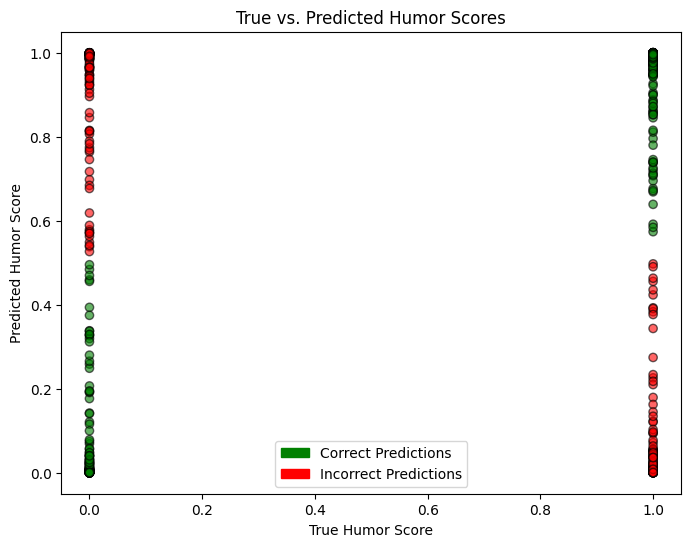

In [14]:
#TODO: Plotting
'''
# Definiere korrekte und falsche Vorhersagen basierend auf einem Schwellenwert
threshold = 0.5
predicted_labels = (np.array(predictions) > threshold).astype(int)
true_labels = (np.array(actuals) > threshold).astype(int)

# Bool-Array für korrekte Vorhersagen
correct = predicted_labels == true_labels

# Farben zuordnen: Grün für korrekt, Rot für falsch
colors = ['green' if is_correct else 'red' for is_correct in correct]

# Scatter-Plot
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, c=colors, alpha=0.6, edgecolor='k')


# Legende anpassen
import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='Correct Predictions')
red_patch = mpatches.Patch(color='red', label='Incorrect Predictions')
plt.legend(handles=[green_patch, red_patch])

# Achsen und Titel
plt.title('True vs. Predicted Humor Scores')
plt.xlabel('True Humor Score')
plt.ylabel('Predicted Humor Score')
plt.show()
'''


239


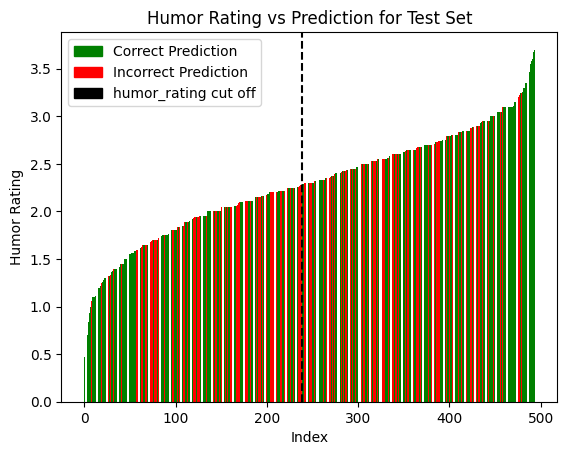

In [15]:
'''
#TODO: Plotting
import pandas as pd

# Load the data from csv
df = pd.read_csv('data/hack.csv')
df_test = df.iloc[test_dataset.original_indices].copy()
df_test['prediction'] = predicted_labels
df_test['label'] = true_labels
df_test['pred_correct'] = (df_test['prediction'] == df_test['label'])

df_test_sorted = df_test.sort_values(by='humor_rating').reset_index(drop=True)

from matplotlib import patches as mpatches

median_rating = df['humor_rating'].median()
# get first index where humor_rating is greater than median_rating
median_idx = df_test_sorted[df_test_sorted['humor_rating'] > median_rating].index[0]
print(median_idx)
# range idx for len df_test
range_idx = range(len(df_test))
colors = df_test_sorted['pred_correct'].map({True: 'g', False: 'r'})
# bar plot for each df_test humor_rating value 
plt.bar(range_idx, df_test_sorted['humor_rating'], color=colors)
# vertical line for True/False cut off
plt.axvline(x=median_idx, color='black', linestyle='--')
# Create a legend handles
green_patch = mpatches.Patch(color='g', label='Correct Prediction')
red_patch = mpatches.Patch(color='r', label='Incorrect Prediction')
line_patch = mpatches.Patch(color='black', label='humor_rating cut off')
plt.title('Humor Rating vs Prediction for Test Set')
plt.xlabel('Index')
plt.ylabel('Humor Rating')
plt.legend(handles=[green_patch, red_patch, line_patch])
plt.show()
''''''